# Linear regression

## En esta parte, voy a ir describiendo el proceso y los pasos necesarios para construir un riguroso modelo de Regresion Lineal que nos permita predecir los valores de la futura temperatura media diaria basandonos en el dataSet que ya tenemos preparado
## Usare dos de las librerias mas importantes de python para la industria del Machine Learning: Scikit-Learn y StatsModels

### Abrimos el dataframe exportado de la primera parte

In [46]:
import pickle
with open('end-part1_df.pkl', 'rb') as fp:
    df = pickle.load(fp)

### Utilizaremos un modelo de regresion lineal con el algoritmo de MCO (minimos cuadrados ordinarios)

[Informacion sobre que es la regresion lineal](https://es.wikipedia.org/wiki/Regresi%C3%B3n_lineal)

[Informacion sobre el método utilizado para encontrar los parámetros poblacionales en un modelo de regresión lineal](https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados_ordinarios)

QUIZA dar mas explicaciones de la regresion y su algoritmo

## Eligiendo las caracteristicas de nuestro modelo

#### Un punto clave que se asume cuando se utiliza la tecnica de regresion lineal es que tenemos una relacion lineal entre la variable dependiente y cada una de las variables independientes

#### Una forma de comprobar la linealidad entre nuestra variable independiente, que sera la TEMPERATURA MEDIA y las otras variables independientes, consiste en calcula el [coeficiente de correlacion de Pearson](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) 

#### La siguiente tabla indica como se interpreta el coeficiente:



| Correlation Value | Interpretation |
| -- | -- |
| 0.8 - 1.0 | Very Strong |
| 0.6 - 0.8| Strong |
| 0.4 - 0.6 | Moderate |
| 0.2 - 0.4 | Weak |
| 0.0 - 0.2 | Very weak |



#### Para obtener la correlacion de nuestro dataSet, utilizaremos el metodo ` corr()`  de Pandas DataFRame Object. Le pasaremos la columna en la que estamos interesados, que en este caso es 'tmed' y despues ordenamos el resultado desde los menos correlacionados a los mascorrelacionados

In [47]:
df.corr()[['tmed']].sort_values('tmed')

,tmed
prec_1,-0.131943
prec_2,-0.121593
prec_3,-0.109075
tmin_3,0.866754
tmin_2,0.884268
tmax_3,0.901946
tmin_1,0.915285
tmed_3,0.918337
tmax_2,0.919749
tmed_2,0.936532


#### A partir de estos resultados, he decidido eliminar las variables que tengan el coeficiente de correlacion menor que 0.6 y tambien tmed,tmin y tmax. Ya que tienen que ver con el dia que voy a buscar predecir En este caso mantendre tmed, para tener un array cuadrado, pero saldra una linea recta en las graficas de abajo

#### Creo el nuevo dataframe:

In [48]:
df2 = df.drop(['prec_1', 'prec_2', 'prec_3'], axis=1)
predictors = ['tmed_1','tmed_2','tmed_3','tmin_1','tmin_2','tmin_3','tmax_1','tmax_2', 'tmax_3', 'tmed']

## Visualizando las relaciones

#### Mediante matplotlib voy a dibujar las variables que usare para la prediccion, para comprobar visualmente de que existe una relacion lineal

In [49]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#### Voy a colocar la variable dependiente tmed en el eje Y y las otras 11 variables sobre el eje X.

#### Además hare una estructura de cuadrados para que se vea mas claramente

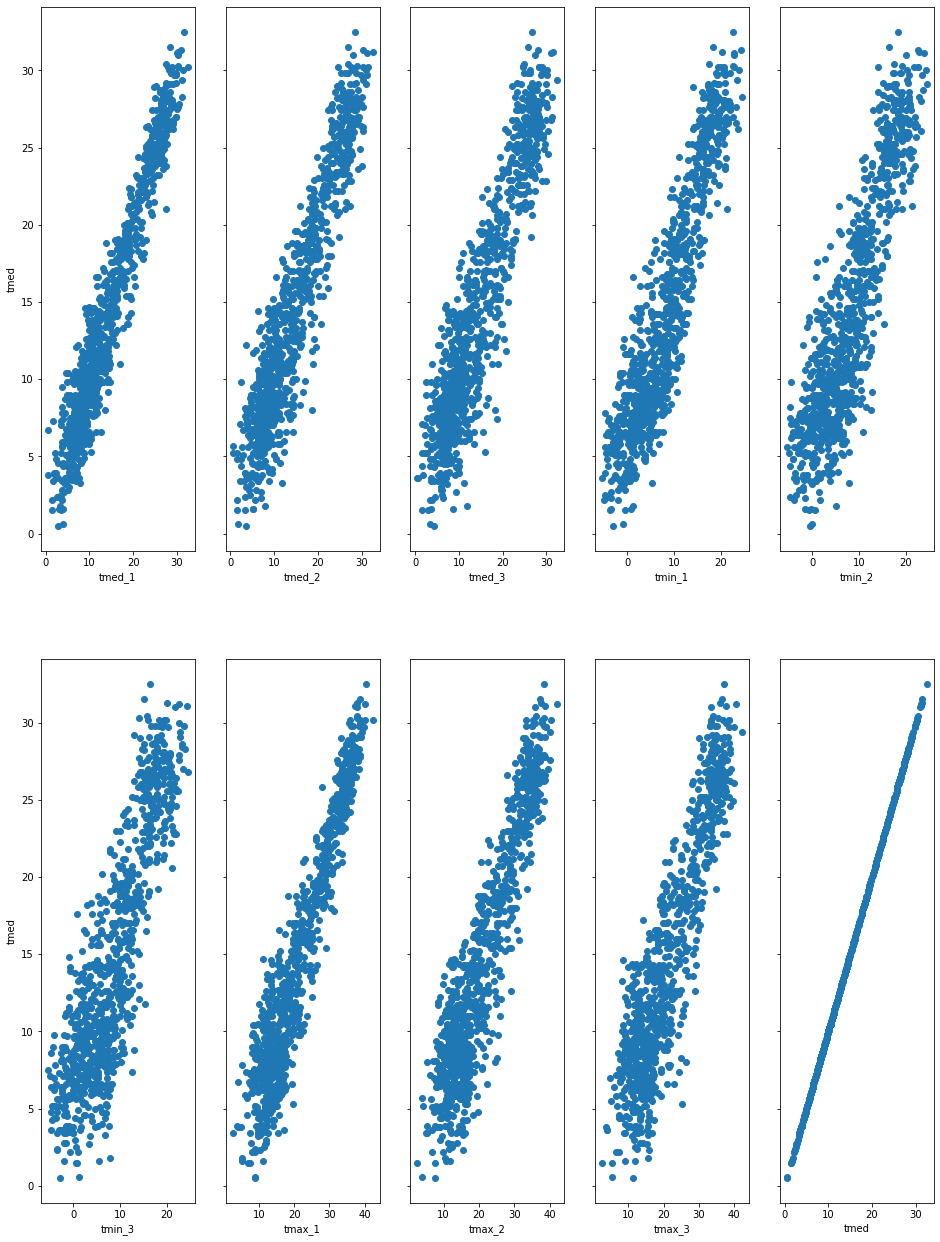

In [50]:
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that 
# the y axes should be shared
fig, axes = plt.subplots(nrows=2, ncols=5, sharey=True)

# Since it would be nice to loop through the features in to build this plot
# let us rearrange our data into a 2D array of 6 rows and 3 columns
arr = np.array(predictors).reshape(2, 5)

# use enumerate to loop over the arr 2D array of rows and columns
# and create scatter plots of each meantempm vs each feature
for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['tmed'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='tmed')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

#### Observando las graficas, se puede observar como las variables de prediccion muestran una buena relacion lineal con la variable a predercir, tmed

#### Ademas se puede observar .....

In [51]:
#Quito ya el tmed de predictors
predictors = ['tmed_1','tmed_2','tmed_3','tmin_1','tmin_2','tmin_3','tmax_1','tmax_2', 'tmax_3']

## Usando regresion gradual para construir un modelo robusto

#### Un modelo de regresion lineal robusto debe utilizar test estadisticos para seleccionar los indicadores significativos.

#### Para seleccionar las caracteristicas estadisticas, utilizare la libreria de python `statsmodels`.

#### Antes de continuar con la practica, voy a hablar un poco de teoria.
#### Un punto muy importante a la hora de trabajar con regresion lineal, es la valided y correcion de las hipotesis que se hacen sobre los datos a estudiar. Una forma de comprobar estas hipotesis es evaluando la importancia de cada una de las variables incluidas en la prediccion. TODO: ver si ampliar
#### De este modo, seleccionariamos de manera mucho mas minuciosa las variables a incluir y obtendriamos un modelo mas robusto

#### Aun asi, en muchos datasets puede haber interacciones  que ocurren entre variables que den lugar a falsas interpretaciones en estos simples test de hipotesis.

#### Por ello, para testear si son significativos los efectos de las interacciones de cada una de las variables en un modelo de regresion, se utiliza la [regresion gradual o progresiva](https://en.wikipedia.org/wiki/Stepwise_regression#:~:text=In%20statistics%2C%20stepwise%20regression%20is,based%20on%20some%20prespecified%20criterion.). Esta nos permite ir añadiendo o eliminando variables del modelo e ir validando si hay importancia estadistica de cada una de las variables en el modelo resultante.

#### PONER EXPLICACION DE LOS 5 PASOS DE BACKWARD ELIMINATION

#### Comienzo ya con la parte practica, para aplicar lo explicado mediante `statsmodels`

In [52]:
# Importamos el modulo
import statsmodels.api as sm

# Separo mis variables de prediccion (X) de mi variable de resultado Y
X = df2[predictors]
y = df2['tmed']

#Añadimos una constante al conjunto de variables de prediccion para representar como de importante es la interseccion
# Add a constant to the predictor variable set to represent the Bo intercept
X = sm.add_constant(X)
X.iloc[:5, :5]

,const,tmed_1,tmed_2,tmed_3,tmin_1
fecha,,,,,
2018-01-04,1.0,11.2,10.4,6.9,6.8
2018-01-05,1.0,11.8,11.2,10.4,7.9
2018-01-06,1.0,7.8,11.8,11.2,5.2
2018-01-07,1.0,3.3,7.8,11.8,1.3
2018-01-08,1.0,1.8,3.3,7.8,-0.1


In [53]:
# APLICAMOS LOS PASOS DEL ALGORTIMO
# (1) select a significance value
alpha = 0.05

# (2) Fit the model
# OLS --> Ordinary Least Squares
model = sm.OLS(y, X).fit()

# (3) evaluate the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   tmed   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1449.
Date:                Sat, 15 May 2021   Prob (F-statistic):               0.00
Time:                        18:06:42   Log-Likelihood:                -1911.5
No. Observations:                 912   AIC:                             3843.
Df Residuals:                     902   BIC:                             3891.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0528      0.215      0.245      0.806      -0.370       0.475
tmed_1        -0.3765      1.884     -0.200      0.842      -4.075       3.322
tmed_2        -0.7580      1.881     -0.403      0.687      -4.449       2.933
tmed_3        -2.8182      1.875     -1.503      0.133      -6.497       0.861
tmin_1         0.5774      0.944      0.611      0.541      -1.276       2.431
tmin_2         0.3322      0.942      0.353      0.725      -1.517       2.182
tmin_3         1.5115      0.939      1.610      0.108      -0.331       3.354
tmax_1         0.6777      0.942      0.719      0.472      -1.171       2.527
tmax_2         0.3502      0.941      0.372      0.710      -1.496       2.196
tmax_3         1.4675      0.937      1.566      0.118      -0.372       3.307
==============================================================================
Omnibus:                        1.639   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.441   Jarque-Bera (JB):                1.536
Skew:                          -0.097   Prob(JB):                        0.464
Kurtosis:                       3.052   Cond. No.                     1.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### La llamada anterior nos ha dado mucha informacion, pero no nos es necesaria toda.

#### Nos interesan 3
1. P>|t| --> Es el valor que utilizaremos para evaluar nuestro test de hipotesis. Este valor lo vamos a usar para determinar si eliminar una variable o no enNos mode esta tecnica de eliminacion gradual.
2. R-squared --> Es el porcentaje de la variación en la variable de respuesta que es explicado por nuestro modelo.
3. Adj. R-squared --> Se utiliza en la regresión múltiple para ver el grado de intensidad o efectividad que tienen las variables independientes en explicar la variable dependiente.

#### Esto no significa que el resto de datos sean insignificativos, pero nosotros no los usaremos, si quieres saber mas sobre ellos, puedes consultar el manual de la libreria [statsmodels](https://www.statsmodels.org/stable/api.html)

In [54]:
# (3) cont. - Identificamos la variable de prediccion con el mayor valor en p y comprobamos si es mayor que nuestro alpha seleccionado
#             fijandonos en la tabla, se ve claramente que tmed_1 tiene el maximo valor en p y
#             ademas en mayor que nuestro alpha de 0.05

# (4) - Usamos la funcion drop de pandas para eliminar esta columna de X

X = X.drop('tmed_1', axis=1)

# (5) Fit the model 
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   tmed   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1632.
Date:                Sat, 15 May 2021   Prob (F-statistic):               0.00
Time:                        18:06:43   Log-Likelihood:                -1911.5
No. Observations:                 912   AIC:                             3841.
Df Residuals:                     903   BIC:                             3884.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0513      0.215      0.238      0.812      -0.371       0.473
tmed_2        -0.7585      1.880     -0.404      0.687      -4.447       2.930
tmed_3        -2.8137      1.873     -1.502      0.133      -6.490       0.863
tmin_1         0.3888      0.029     13.374      0.000       0.332       0.446
tmin_2         0.3324      0.942      0.353      0.724      -1.516       2.181
tmin_3         1.5094      0.938      1.609      0.108      -0.332       3.351
tmax_1         0.4895      0.024     20.199      0.000       0.442       0.537
tmax_2         0.3505      0.940      0.373      0.709      -1.494       2.195
tmax_3         1.4653      0.937      1.565      0.118      -0.373       3.303
==============================================================================
Omnibus:                        1.650   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.438   Jarque-Bera (JB):                1.546
Skew:                          -0.097   Prob(JB):                        0.462
Kurtosis:                       3.052   Cond. No.                     1.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Volvemos al paso 3 del algortimo 

#### Como el maximo valor de p sigue siendo mayor que nuestro aplha (0.05), seguimos con el algoritmo

In [55]:
# (3) cont. - Identificamos la variable de prediccion con el mayor valor en p y comprobamos si es mayor que nuestro alpha seleccionado
#             fijandonos en la tabla, se ve claramente que tmin_2 tiene el maximo valor en p y
#             ademas en mayor que nuestro alpha de 0.05

# (4) - Usamos la funcion drop de pandas para eliminar esta columna de X

X = X.drop('tmin_2', axis=1)

# (5) Fit the model 
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   tmed   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1866.
Date:                Sat, 15 May 2021   Prob (F-statistic):               0.00
Time:                        18:06:44   Log-Likelihood:                -1911.6
No. Observations:                 912   AIC:                             3839.
Df Residuals:                     904   BIC:                             3878.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0476      0.215      0.222      0.825      -0.374       0.469
tmed_2        -0.0956      0.070     -1.375      0.169      -0.232       0.041
tmed_3        -2.8133      1.872     -1.502      0.133      -6.488       0.862
tmin_1         0.3891      0.029     13.393      0.000       0.332       0.446
tmin_3         1.5096      0.938      1.610      0.108      -0.331       3.350
tmax_1         0.4896      0.024     20.213      0.000       0.442       0.537
tmax_2         0.0192      0.048      0.401      0.689      -0.075       0.113
tmax_3         1.4652      0.936      1.565      0.118      -0.372       3.302
==============================================================================
Omnibus:                        1.653   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.438   Jarque-Bera (JB):                1.551
Skew:                          -0.098   Prob(JB):                        0.460
Kurtosis:                       3.050   Cond. No.                     1.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Volvemos al paso 3 del algortimo 

#### Como el maximo valor de p sigue siendo mayor que nuestro aplha (0.05), seguimos con el algoritmo

In [56]:
# (3) cont. - Identificamos la variable de prediccion con el mayor valor en p y comprobamos si es mayor que nuestro alpha seleccionado
#             fijandonos en la tabla, se ve claramente que tmed_3 tiene el maximo valor en p y
#             ademas en mayor que nuestro alpha de 0.05

# (4) - Usamos la funcion drop de pandas para eliminar esta columna de X

X = X.drop('tmed_3', axis=1)

# (5) Fit the model 
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   tmed   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     2174.
Date:                Sat, 15 May 2021   Prob (F-statistic):               0.00
Time:                        18:06:44   Log-Likelihood:                -1912.7
No. Observations:                 912   AIC:                             3839.
Df Residuals:                     905   BIC:                             3873.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0338      0.215      0.157      0.875      -0.387       0.455
tmed_2        -0.0954      0.070     -1.372      0.171      -0.232       0.041
tmin_1         0.3891      0.029     13.384      0.000       0.332       0.446
tmin_3         0.1012      0.028      3.616      0.000       0.046       0.156
tmax_1         0.4903      0.024     20.229      0.000       0.443       0.538
tmax_2         0.0191      0.048      0.400      0.690      -0.075       0.113
tmax_3         0.0593      0.025      2.356      0.019       0.010       0.109
==============================================================================
Omnibus:                        1.793   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.670
Skew:                          -0.099   Prob(JB):                        0.434
Kurtosis:                       3.070   Cond. No.                         148.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Ahora que ya hemos realizado todos los pasos para obtener las variables de prediccion que son significativas, podemos utilizar la biblioteca [Scikit-Learn](https://scikit-learn.org/stable/) para crear un modelo de prediccion y testear su habilidad para predecir la temperatura media.

#### Comenzamos usando usando SciKit-learn para dividir nuestro dataset en varios para irlos testeando y entrenando. Nos valdremos de la funcion `train_test_split()` del modulo `sklearn.model_selection`

#### Separaremos los dataset en 80% entrenamiento y 20% test. Y asignaremos un `random_state` de 12. Este random_state es muy util para la reproducibilidad de los resultados.

Random state: Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
# first remove the const column because unlike statsmodels, SciKit-Learn will add that in for us
X = X.drop('const', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


#### El siguiente paso es construir un modelo de regresion usando el dataset de entrenamiento.

#### Para ello importaremos y usaremos la clase `LinearRegression` desde el modulo `sklearn.linear_model`

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
# instantiate the regressor class
regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

print( type(prediction))
# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, prediction))

<class 'numpy.ndarray'>
The Explained Variance: 0.93
The Mean Absolute Error: 1.61 degrees celsius
The Median Absolute Error: 1.38 degrees celsius


#### To gain an interpretative understanding of the models validity I used the regressor model's `score()` function to determine that the model is able to explain about 90% of the variance observed in the outcome variable, mean temperature. Additionally, I used the `mean_absolute_error()` and `median_absolute_error()` of the sklearn.metrics module to determine that on average the predicted value is about 3 degrees Celsius off and half of the time it is off by about 2 degrees Celsius.

In [44]:
df2.to_csv (r'end-part2.csv', header=True)

In [65]:
import pickle
with open('end-part2_df.pkl', 'wb') as fp:
    pickle.dump(df2, fp)

In [64]:
#import pickle
#with open('end-part2_df.pkl', 'wb') as fp:
#    pickle.dump(X, fp)